## Airline sentiment classification with RNN
- The dataset contains reviews obtained from twitter, with sentiment labels (positive, neutral, or negative) for six US airlines.

With an abundance of reviews thorugh many different social platfoms, airlines find it hard to analyse every review to discover good or bad points noted by customers.

Hence, through the creation of a RNN sentiment prediction of airline reviews, all airlines will be able to use this model to label past and future reviews.

This helps them to further segregate positive and negative reviews, to perform further analysis on each dataset.
- Identify areas worthy of compliment, or areas of improvement.
- Discover relationship between good points / bad points.
- Analyze how trends in sentiment are affected by trends around the world.


In [ ]:
# pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ADL/assignment23aug/twitterUSairline.zip

Archive:  /content/drive/MyDrive/ADL/assignment23aug/twitterUSairline.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [ ]:
import os
import shutil
import tensorflow as tf

from datetime import datetime
import tensorflow as tf

In [ ]:
import pandas as pd

# read dataset
df = pd.read_csv('Tweets.csv')

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
print(f'Total number of reviews is {df.shape[0]}')
print(f'Number of classes in \n {df.airline_sentiment.value_counts()}')

Total number of reviews is 14640
Number of classes in 
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [ ]:
# split data into training and test dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)

# Separate out our target values
y_train = train['airline_sentiment'].tolist()
y_test = test['airline_sentiment'].tolist()

# Separate out text data
x_train = train['text'].tolist()
x_test = test['text'].tolist()

print('size of training set is ', len(x_train))
print('size of test set is ', len(x_test))

size of training set is  11712
size of test set is  2928


In [ ]:
print(f'Number of classes is training data \n {train.airline_sentiment.value_counts()}')

Number of classes is training data 
 negative    7308
neutral     2485
positive    1919
Name: airline_sentiment, dtype: int64


The data is significantly imbalanced, with a 240k rows difference between positive and neutral class

In [ ]:
x_train[:5]

['@JetBlue yes thankfully! Catering just got here and now they are loading, but very frustrated. I was supposed to be there by 10-10:30',
 "@united yes I have &amp; they're unsure when it would come.This has never happened on any airline and my first time with @united #disappointed",
 "@united Wife and I have two new destinations and I'm stuck in DC until Monday with no bags",
 "@united Why do I still not have my bags? They arrived @10AM &amp;website says they're still at the airport..2 1/2 hours Late Flightr???!! #nothappy",
 "@AmericanAir @dfwairport That's DFW!? OMG! Yeah cold, everywhere!"]

In [ ]:
y_train[:5]

['positive', 'negative', 'negative', 'negative', 'neutral']

preprocess data

In [ ]:
# transform target column from text to numerical values
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the label column
y_train_labelled = label_encoder.fit_transform(y_train)
y_test_labelled = label_encoder.fit_transform(y_test)

# Turn our scalar targets into binary categories
num_classes = 3
y_train = keras.utils.to_categorical(y_train_labelled, num_classes)
y_test = keras.utils.to_categorical(y_test_labelled, num_classes)

In [ ]:
# create tf.data.dataset freom value lists

batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(batch_size)

In [ ]:
for text_batch, label_batch in test_dataset.take(1): # take one batch
    for i in range(3):
        print(label_batch[i].numpy(), text_batch[i].numpy())

[1. 0. 0.] b"@AmericanAir In car gng to DFW. Pulled over 1hr ago - very icy roads. On-hold with AA since 1hr. Can't reach arpt for AA2450. Wat 2 do?"
[1. 0. 0.] b'@AmericanAir after all, the plane didn\xe2\x80\x99t land in identical or worse) conditions at GRK according to METARs.'
[1. 0. 0.] b"@SouthwestAir can't believe how many paying customers you left high and dry with no reason for flight Cancelled Flightlations Monday out of BDL! Wow."


- Negative : 0
- Neutral : 1
- Positive : 2



In [ ]:
len(train_dataset)

92

Configure dataset for good performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize reviews.

In [ ]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000  # number of unique words, larger = more complex
MAX_SEQUENCE_LENGTH = 200
# Use the text vectorization layer to normalize, split, and map strings to
# integers.
# Set maximum_sequence length as all samples are not of the same length. if sentence is more than max seq length, cut off sentence
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


# sequence_length = 128
# input_features = 256
# vocab_size = 10000
# batch_size = 32

# train_dataset = tf.data.Dataset.from_tensor_slices((tf.random.uniform((batch_size, sequence_length, input_features)), tf.random.uniform((batch_size,))))
# test_dataset = tf.data.Dataset.from_tensor_slices((tf.random.uniform((batch_size, sequence_length, input_features)), tf.random.uniform((batch_size,))))


In [ ]:
print(len(vectorize_layer.get_vocabulary())) # select words based on feature importance

10000


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

### create a multiclass classification model (neutral, positive, neutral)

In [ ]:
EMBEDDING_DIM = 128
num_classes = 3  # Number of sentiment classes

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBEDDING_DIM,
                              mask_zero=True,
                              name='embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

- vectorize layer is a preprocessing step that tokenizes input data and converts tokens into numerical format to be able to be fed into the recurrent neural network.
- embedding layer converts the numerical representation of words into embeddings. Each embedding value is learned during the training process.
- Bidirectional LSTM layers allows the model to train using context from both past and future tokens, which immproves it sunderstanding of the sequential patterns in the text.
- The dense layer with 64 units applies the ReLU function to introduce non-linearity to learn relationships between the outputs of the LSTM layer. The final dense layer uses a softmax activation function to produce probabilities of each class for the input data.

compile and train the model

In [ ]:
#Create an instance of Stochastic Gradient Descent (SGD) optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.85)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# use early stoppingg callback to stop training when there is no improvement after x number of epochs
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, verbose=0,
    mode='auto', restore_best_weights=True)

Compute class weights, to account for imbalanced training data

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in enumerate(class_counts)}



In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[earlystop_callback],
    class_weight=class_weights)

Epoch 1/20
92/92 [==============================] - 36s 164ms/step - loss: 1.0912 - accuracy: 0.5562 - val_loss: 1.0571 - val_accuracy: 0.6120
Epoch 2/20
92/92 [==============================] - 4s 43ms/step - loss: 1.0546 - accuracy: 0.6165 - val_loss: 0.9625 - val_accuracy: 0.5847
Epoch 3/20
92/92 [==============================] - 3s 32ms/step - loss: 1.0212 - accuracy: 0.5785 - val_loss: 0.9923 - val_accuracy: 0.5519
Epoch 4/20
92/92 [==============================] - 3s 32ms/step - loss: 0.9955 - accuracy: 0.5768 - val_loss: 0.8823 - val_accuracy: 0.6212
Epoch 5/20
92/92 [==============================] - 4s 44ms/step - loss: 0.9409 - accuracy: 0.6131 - val_loss: 0.8336 - val_accuracy: 0.6291
Epoch 6/20
92/92 [==============================] - 4s 41ms/step - loss: 0.8776 - accuracy: 0.6457 - val_loss: 0.7081 - val_accuracy: 0.6954
Epoch 7/20
92/92 [==============================] - 3s 33ms/step - loss: 0.7993 - accuracy: 0.6794 - val_loss: 0.6573 - val_accuracy: 0.7258
Epoch 8/20


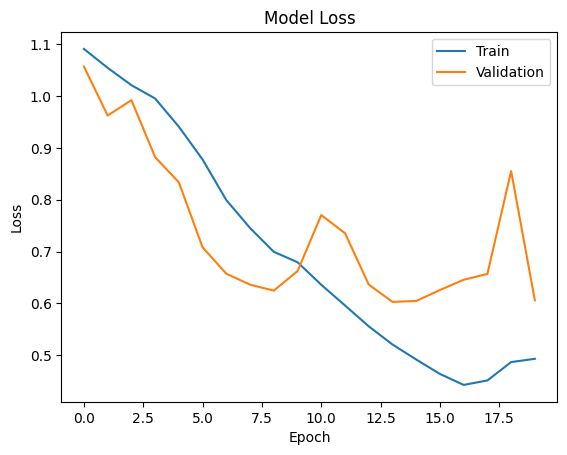

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

evaluate results

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_preds = []
y_labels = []

for texts, labels in test_dataset:
    preds = model.predict(texts)
    preds_classes = np.argmax(preds, axis=1)  # Get the index of the class with the highest probability
    y_preds.extend(preds_classes)

    # Convert one-hot encoded labels to integer format
    labels_int = np.argmax(labels.numpy(), axis=1)
    y_labels.extend(labels_int)


print(classification_report(y_labels, y_preds))


4/4 [==============================] - 6s 9ms/step
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1870
           1       0.54      0.64      0.59       614
           2       0.68      0.76      0.72       444

    accuracy                           0.76      2928
   macro avg       0.70      0.74      0.71      2928
weighted avg       0.78      0.76      0.77      2928



In [ ]:
unique, counts = np.unique(y_train_labelled, return_counts=True)

print('Class counts in training dataset \n',np.asarray((unique, counts)).T)

Class counts in training dataset 
 [[   0 7308]
 [   1 2485]
 [   2 1919]]


> The model has a good performance on the test dataset, yielding an accuracy of 75%.

> In the training process, there is only a slight difference in loss/accuracy and validation loss/accuracy, which shows that the model is not overfitting on the training data.

- From the classification report, it is evident that the class with the largest amount of data (Negative) has higher number of correct predictions made. The model is therefore best at predicting instances of class 0, as seen from the high precision and recall.

- although class 1 has more training data than class 2, the model has more difficulty correctly classifying instances of class 1, as both precision and recall are relatively low.

- For class 2, the precision suggests that when the model frequently correctly classifies instances as class 2, but the lower recall indicates that the model is unable to identify many instances of class 2.